In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata
from dask.distributed import Client

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','tidal_melting','figures')
int_dir = os.path.join(data_dir,'interim')
raw_dir = os.path.join(data_dir,'raw')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

In [30]:
grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

file_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009_avg.nc')
tides = xr.open_dataset(file_path).squeeze()

file_path = os.path.join(data_dir,'raw','waom4_nt','ocean_avg_0009_avg.nc')
no_tides = xr.open_dataset(file_path).squeeze()

grd.mask_rho[570:610,1030:1140] = False

s2a = 365.25*24*3600

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True

In [25]:
def make_uv_mag(u,v): 
    u_rho,v_rho = rotate_vector_roms(u.values,v.values,np.zeros_like(grd.mask_rho))
    return xr.DataArray(xr.ufuncs.sqrt(xr.ufuncs.square(u_rho)+xr.ufuncs.square(v_rho)),dims=('eta_rho','xi_rho'))

def get_vrange(da,vrange):
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=0-2*std
        vmax=0+2*std
    elif vrange=='sat':
        vmax = max(da.max(),np.abs(da.min()))
        vmin = -vmax
    else:
        vmax=vrange[1]
        vmin=vrange[0]

    return vmin,vmax

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

def plot_map(ax,da,title,cbar_label,cmap,vrange=None,cb_ext='both',grd=grd,
             sel={'xi_rho':slice(72,1465),'eta_rho':slice(85,1300)},sb=False,secb=False,save=False):
    if sel:
        da = da.isel(sel)
        grd = grd.isel(sel)
        
    vmin,vmax = get_vrange(da,vrange)
    
    #plt.close()
    #fig,ax = plt.subplots(figsize=(8.27,9))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))   
    cp = da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False)
    
    mask_ice = (grd.mask_rho==1) & (grd.zice<0)
    ax.contour(mask_ice, levels=['0.1'], colors=('black'),linewidths=0.5,linestyles='solid')
    ax.contour(grd.mask_rho,levels=['0.1'], colors=('black'),linewidths=0.1,linestyles='solid')
    
    cb = plt.colorbar(cp, ax=ax, pad=0.01, extend=cb_ext)
    cb.set_label(label=cbar_label,weight='bold')   
    ax.set_title("")
    #plt.tight_layout()
    #if save==True:
    #    plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',bbox_inches = "tight")
    #elif save=='hr':
    #    plt.savefig(os.path.join(fig_dir,'map_'+title.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
    #plt.show()
    return ax


def plot_uv_map(ax,da,u,v,title,cbar_label,cmap,vrange=None,bl=5,grd=grd,cb_ext='both',save=False,
                mask_color=grd.mask_rho==1,mask_quiver=None,
                sel={'xi_rho':slice(72,1465),'eta_rho':slice(85,1300)}):  
    
    angle = np.zeros_like(grd.lon_rho.values)
    u_rho,v_rho = rotate_vector_roms(u.values, v.values, angle)
    
    u_rho = u_rho/(np.sqrt(u_rho**2 + v_rho**2))
    v_rho = v_rho/(np.sqrt(u_rho**2 + v_rho**2))
    
    u_rho[~mask_quiver]=np.nan
    v_rho[~mask_quiver]=np.nan
    
    if sel:
        da = da.where(mask_color).isel(sel)
        grd = grd.isel(sel)
        u_rho = u_rho[sel['eta_rho'],sel['xi_rho']]
        v_rho = v_rho[sel['eta_rho'],sel['xi_rho']]
        
    vmin,vmax = get_vrange(da,vrange)
    
    #plt.close()
    #fig,ax = plt.subplots(figsize=(8.27,9))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))   
    cp = da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False)
    
    mask_ice = (grd.mask_rho==1) & (grd.zice<0)
    ax.contour(mask_ice, levels=['0.1'], colors=('black'),linewidths=0.5,linestyles='solid')
    ax.contour(grd.mask_rho,levels=['0.1'], colors=('black'),linewidths=0.1,linestyles='solid')
    
    cb = plt.colorbar(cp, ax=ax, pad=0.01, extend=cb_ext)
    cb.set_label(label=cbar_label,weight='bold')
    
    quiverp = ax.quiver(np.arange(bl/2,grd.mask_rho.shape[1]+bl/2,bl),np.arange(bl/2,grd.mask_rho.shape[0]+bl/2,bl),
                        #rebin(u_rho.data,(grd.eta_rho.size//bl,grd.xi_rho.size//bl)),
                        #rebin(v_rho.data,(grd.eta_rho.size//bl,grd.xi_rho.size//bl)),
                        u_rho[1:grd.mask_rho.shape[0]:bl,1:grd.mask_rho.shape[1]:bl],
                        v_rho[1:grd.mask_rho.shape[0]:bl,1:grd.mask_rho.shape[1]:bl],
                        color='black')#,scale_units='x',scale=1,alpha=alpha)
    
    #plt.tight_layout()
    #if save:
    #    plt.savefig(os.path.join(fig_dir,title.replace('/','_')+'.png'),format='png',dpi=300,bbox_inches = "tight")
        
    #plt.show()
    return ax

In [31]:
uv_mag_tides = make_uv_mag(tides.ubar,tides.vbar)
mask_quiver = (mask_shelf['Total Antarctica']) & (uv_mag_tides*100 > 1)

In [5]:
u_tide = xr.open_dataarray(os.path.join(int_dir,'u_tide_HP.nc'))
#u_tide = u_tide.rename({'xi_rho':'eta_rho','eta_rho':'xi_rho'})

In [6]:
u_diff = tides.ubar-no_tides.ubar
v_diff = tides.vbar-no_tides.vbar
uv_mag_noTides = make_uv_mag(no_tides.ubar,no_tides.vbar)
uv_mag_diff = uv_mag_tides-uv_mag_noTides 

In [12]:
mask = (mask_shelf['Total Antarctica'] == 1) & (grd.mask_rho == 1)
dV = grd.dV.where(mask)
weights = dV/dV.sum('s_rho')
temp_t = (tides.temp*weights).sum('s_rho').where(mask)
temp_nt = (no_tides.temp*weights).sum('s_rho').where(mask)
temp_diff = temp_t - temp_nt

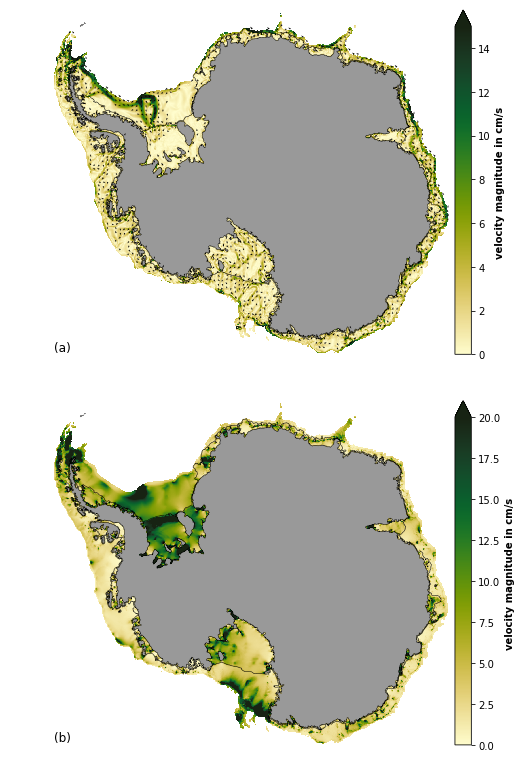

In [21]:
import string
fig,axes = plt.subplots(nrows=2,figsize=(8.27,11))

ax1,ax2 = axes.flatten()

ax1 = plot_uv_map(ax1,uv_mag_tides*100,tides.ubar*100,tides.vbar*100,'2d_currents','velocity magnitude in cm/s',
            ocm.speed,[0,15],15,save=False,
            cb_ext='max',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

ax2 = plot_map(ax2,u_tide.where(mask_shelf['Total Antarctica'])*100,'u_tide','velocity magnitude in cm/s',
            ocm.speed,[0,20],save=False,cb_ext='max')

for n,ax in enumerate([ax1,ax2]):
    ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

plt.tight_layout()

out_path = os.path.join(fig_dir,'velocities.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [ ]:
import string
fig,axes = plt.subplots(nrows=2,figsize=(8.27,11))

ax1,ax2 = axes.flatten()

ax1 = plot_uv_map(ax1,uv_mag_diff*100,u_diff*100,v_diff*100,'2d_currents','velocity magnitude difference in cm/s',
            ocm.balance,[-8,8],15,save=False,
            cb_ext='both',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

ax2 = plot_map(ax2,temp_diff.where(mask_shelf['Total Antarctica']),'temp_diff','Potential temperature difference in  $^{\circ}$C',
            ocm.balance,[-0.5,0.5],save=False,cb_ext='max')

for n,ax in enumerate([ax1,ax2]):
    ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

plt.tight_layout()

out_path = os.path.join(fig_dir,'tidal_change_velocities_temp.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

# residual currents from pseudo barotropic run

In [45]:
uv = []
for year in np.arange(1,7):
    print(year)
    file_path = os.path.join(data_dir,'raw','scratch','waom4_PBT','ocean_avg_000'+str(year)+'.nc')
    pbt = xr.open_dataset(file_path)
    upbt = pbt.ubar.mean('ocean_time')
    vpbt = pbt.vbar.mean('ocean_time')
    uv.append(make_uv_mag(upbt,vpbt))
    

1
2
3
4
5
6


In [53]:
uv_dm = []
for year in np.arange(1,5):
    print(year)
    uv_dm.append(np.max(np.abs(uv[year+1]-uv[year])))

1
2
3
4


In [54]:
uv_dm

[<xarray.DataArray ()>
 array(0.00962), <xarray.DataArray ()>
 array(0.005333), <xarray.DataArray ()>
 array(0.011513), <xarray.DataArray ()>
 array(0.015244)]

In [47]:

np.abs(uv[1:]-uv[:-1]).shape

KeyboardInterrupt: 

In [40]:
plt.close()
plt.plot(np.max(np.abs(uv[1:]-uv[:-1]),1)

<xarray.DataArray ()>
array(0.015244)

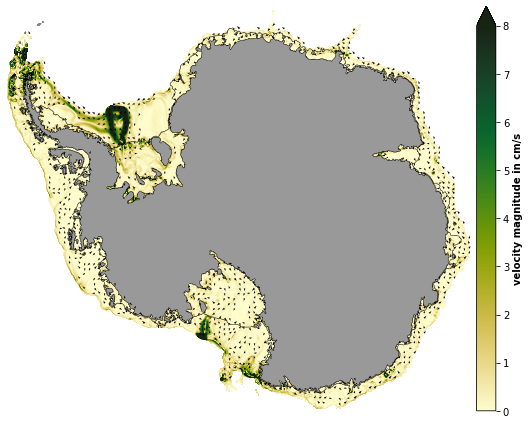

In [56]:
import string

file_path = os.path.join(data_dir,'raw','scratch','waom4_PBT','ocean_avg_0001.nc')
pbt = xr.open_dataset(file_path)
upbt = pbt.ubar.mean('ocean_time')
vpbt = pbt.vbar.mean('ocean_time')
uv.append(make_uv_mag(upbt,vpbt))

fig,ax1 = plt.subplots(nrows=1,figsize=(8.27,6))

ax1 = plot_uv_map(ax1,(uv_mag_pbt)*100,tides.ubar*100,tides.vbar*100,'2d_currents','velocity magnitude in cm/s',
            ocm.speed,[0,8],15,save=False,
            cb_ext='max',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

plt.tight_layout()

out_path = os.path.join(fig_dir,'residual_flow.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [14]:
src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from roms_tools.cartesian_grid_2d import *
from netCDF4 import Dataset
from numpy import *
from matplotlib.pyplot import *
from os.path import *
from roms_tools.cartesian_grid_3d import *
from roms_tools.rotate_vector_roms import *

In [23]:
# %load ../../src/roms_tools/timeseries_3D.py

# Calculate and plot timeseries of total ocean heat content, average salinity, 
# and total kinetic energy during a ROMS simulation.
# Takes 32 GB of memory for Kaitlin's circumpolar quarter-degree grid to 30S.
# Input:
# grid_path = path to ROMS grid file
# file_path = path to ROMS history/averages file
# log_path = path to log file (if it exists, previously calculated values will
#            be read from it; regardless, it will be overwritten with all
#            calculated values following computation)
def timeseries_3D (grid_path, file_path, log_path):

    # Grid parameters
    theta_s = 7.0
    theta_b = 2.0
    hc = 250
    N = 31
    rho0 = 1000.0    # Reference density (kg/m^3)
    Cp = 3974        # Specific heat of polar seawater (J/K/kg)
    C2K = 273.15     # Celsius to Kelvin conversion

    time = []
    ohc = []
    avgsalt = []
    tke = []
    # Check if the log file exists
    if exists(log_path):
        print('Reading previously calculated values')
        f = open(log_path, 'r')
        # Skip first line (header for time array)
        f.readline()
        for line in f:
            try:
                time.append(float(line))
            except(ValueError):
                # Reached the header for the next variable
                break
        for line in f:
            try:
                ohc.append(float(line))
            except(ValueError):
                break
        for line in f:
            try:
                avgsalt.append(float(line))
            except(ValueError):
                break
        for line in f:
            tke.append(float(line))
        f.close()

    print('Analysing grid')
    id = Dataset(grid_path, 'r')
    h = id.variables['h'][:-15,1:-1]
    zice = id.variables['zice'][:-15,1:-1]    
    lon = id.variables['lon_rho'][:-15,1:-1]
    lat = id.variables['lat_rho'][:-15,1:-1]
    mask = id.variables['mask_rho'][:-15,1:-1]
    # Keep the overlapping periodic boundary on "angle" for now
    angle = id.variables['angle'][:-15,:]
    id.close()

    id = Dataset(file_path, 'r')
    # Read time values and convert from seconds to years
    new_time = id.variables['ocean_time'][:]/(60*60*24*365.25)
    num_time = size(new_time)
    # Concatenate with time values from log file
    for t in range(num_time):        
        time.append(new_time[t])

    # Process 10 time indices at a time so we don't use too much memory
    start_t = 0
    while True:
        end_t = min(start_t+10, num_time)
        print('Processing time indices ' + str(start_t+1) + ' to ' + str(end_t))
        num_time_curr = end_t-start_t

        print( 'Calculating time-dependent dV')
        # Read time-dependent sea surface height
        zeta = id.variables['zeta'][start_t:end_t,:-15,1:-1]
        # Calculate time-dependent dz
        dz = ma.empty([num_time_curr, N, size(lon,0), size(lon,1)])
        for t in range(num_time_curr):
            # dx and dy will be recomputed unnecessarily each timestep
            # but that's ok
            dx, dy, dz_tmp, z = cartesian_grid_3d(lon, lat, h, zice, theta_s, theta_b, hc, N, zeta[t,:,:])
            dz[t,:,:,:] = dz_tmp
        # Calculate time-dependent dV and mask with land mask
        # Here mask, dx, dy are all copied into arrays of dimension
        # time x depth x lat x lon
        dV = ma.masked_where(tile(mask, (num_time_curr,N,1,1))==0, tile(dx, (num_time_curr,1,1,1))*tile(dy, (num_time_curr,1,1,1))*dz)

        print('Reading data')
        temp = id.variables['temp'][start_t:end_t,:,:-15,1:-1]
        salt = id.variables['salt'][start_t:end_t,:,:-15,1:-1]
        rho = id.variables['rho'][start_t:end_t,:,:-15,1:-1] + rho0
        # Keep overlapping periodic boundary for u and v
        u_xy = id.variables['u'][start_t:end_t,:,:-15,:]
        v_xy = id.variables['v'][start_t:end_t,:,:-15,:]

        print( 'Interpolating velocities onto rho-grid')
        # We are actually rotating them at the same time as interpolating
        # which is a bit of unnecessary work (sum of squares won't change with
        # rotation) but not much extra work, and it's conveneint
        u = ma.empty(shape(temp))
        v = ma.empty(shape(temp))
        for t in range(num_time_curr):
            for k in range(N):
                u_tmp, v_tmp = rotate_vector_roms(u_xy[t,k,:,:], v_xy[t,k,:,:], angle)
                u[t,k,:,:] = u_tmp[:,1:-1]
                v[t,k,:,:] = v_tmp[:,1:-1]

        print( 'Building timeseries')
        for t in range(num_time_curr):
            # Integrate temp*rho*Cp*dV to get OHC
            ohc.append(sum((temp[t,:,:,:]+C2K)*rho[t,:,:,:]*Cp*dV[t,:,:,:]))
            # Average salinity (weighted with rho*dV)
            avgsalt.append(sum(salt[t,:,:,:]*rho[t,:,:,:]*dV[t,:,:,:])/sum(rho[t,:,:,:]*dV[t,:,:,:]))
            # Integrate 0.5*rho*speed^2*dV to get TKE
            tke.append(sum(0.5*rho[t,:,:,:]*(u[t,:,:,:]**2 + v[t,:,:,:]**2)*dV[t,:,:,:]))

        # Get ready for next 10 time indices
        if end_t == num_time:
            break
        start_t = end_t

    id.close()

    print( 'Plotting ocean heat content')
    clf()
    plot(time, ohc)
    xlabel('Years')
    ylabel('Southern Ocean Heat Content (J)')
    grid(True)
#    savefig('ohc.png')

    #print 'Plotting average salinity'
    clf()
    plot(time, avgsalt)
    xlabel('Years')
    ylabel('Southern Ocean Average Salinity (psu)')
    grid(True)
#    savefig('avgsalt.png')

    print( 'Plotting total kinetic energy')
    clf()
    plot(time, tke)
    xlabel('Years')
    ylabel('Southern Ocean Total Kinetic Energy (J)')
    grid(True)
#    savefig('tke.png')

    #print 'Saving results to log file'
    f = open(log_path, 'w')
    f.write('Time (years):\n')
    for elm in time:
        f.write(str(elm) + '\n')
    f.write('Southern Ocean Heat Content (J):\n')
    for elm in ohc:
        f.write(str(elm) + '\n')
    f.write('Southern Ocean Average Salinity (psu):\n')
    for elm in avgsalt:
        f.write(str(elm) + '\n')
    f.write('Southern Ocean Total Kinetic Energy (J):\n')
    for elm in tke:
        f.write(str(elm) + '\n')
    f.close()


# Command-line interface
#if __name__ == "__main__":
grid_path = os.path.join(int_dir,'grd4_dV.nc')#raw_input("Path to ROMS grid file: ")
file_path = os.path.join(data_dir,'raw','scratch','waom4_PBT','ocean_avg_0001.nc')#raw_input("Path to ROMS history/averages file: ")
log_path = os.path.join(int_dir,'log.txt')#raw_input("Path to logfile to save values and/or read previously calculated values: ")

timeseries_3D(grid_path, file_path, log_path)


    

    


Analysing grid
Processing time indices 1 to 10
Calculating time-dependent dV


TypeError: cartesian_grid_2d() missing 2 required positional arguments: 'lon_v' and 'lat_v'

In [ ]:
file_path = os.path.join(data_dir,'raw','scratch','waom4_PBT','ocean_avg_0006.nc')
pbt = xr.open_dataset(file_path)
upbt = pbt.ubar.mean('ocean_time')
vpbt = pbt.vbar.mean('ocean_time')
uv_mag_pbt = make_uv_mag(upbt,vpbt)

In [ ]:
from dask.distributed import Client
C = Client()
C

In [13]:
uv = []
for i in np.arange(1,7):
    print(i)
    file_path = os.path.join(data_dir,'raw','scratch','waom4_PBT','ocean_avg_000'+str(i)+'.nc')
    pbt = xr.open_dataset(file_path)
    uv.append(xr.ufuncs.sqrt(xr.ufuncs.square(pbt.u_rho)+xr.ufuncs.square(pbt.v_rho)).load())

1


MemoryError: 

In [ ]:
plt.plot(np.array(uv))

In [ ]:
file_path = os.path.join(data_dir,'raw','scratch','waom4_PBT','ocean_avg_0006.nc')
pbt = xr.open_mfdataset(file_path)
u = pbt.ubar.where(mask).mean().load()
#v = pbt.vbar.where(mask).mean(['xi_v','eta_v']).load()
#print('ping')
#uv = xr.ufuncs.sqrt(xr.ufuncs.square(u)+xr.ufuncs.square(v)).load()

In [159]:
AP_sel = {'xi_rho':slice(0,200),'eta_rho':slice(1000,1200)}
SC_sel = {'xi_rho':slice(1200,1400),'eta_rho':slice(900,1100)}

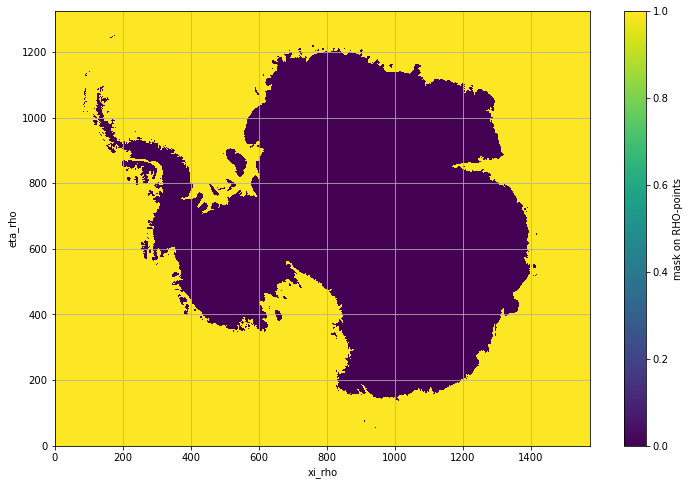

In [153]:
grd.mask_rho.plot(size=8)
plt.grid()

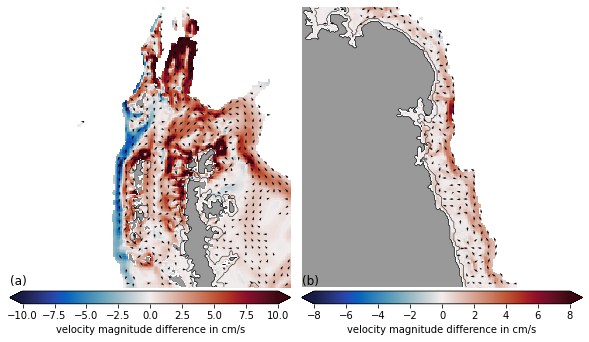

In [171]:
import string
fig,axes = plt.subplots(ncols=2,figsize=(8.27,5))

ax1,ax2 = axes.flatten()

ax1 = plot_uv_map(ax1,uv_mag_diff*100,u_diff*100,v_diff*100,'2d_currents','velocity magnitude difference in cm/s',
            ocm.balance,[-10,10],5,save=False,sel=AP_sel,
            cb_ext='both',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

ax2 = plot_uv_map(ax2,uv_mag_diff*100,u_diff*100,v_diff*100,'2d_currents','velocity magnitude difference in cm/s',
            ocm.balance,[-8,8],5,save=False,sel=SC_sel,
            cb_ext='both',mask_quiver=mask_quiver,mask_color=mask_shelf['Total Antarctica'])

for n,ax in enumerate([ax1,ax2]):
    ax.text(0.0, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

plt.tight_layout()

out_path = os.path.join(fig_dir,'tidal_change_velocities_zoom_ins.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

In [18]:
import pickle
pickle_in = open(os.path.join(int_dir,"var_tides2.pkl"),"rb")
var = pickle.load(pickle_in)

In [25]:
mask = (mask_shelf['Total Antarctica']) &(grd.zice<0)

In [36]:
sel_Amery = {'xi_rho':slice(1169,1325),'eta_rho':slice(780,920)}
sel_Ronne = {'xi_rho':slice(360,550),'eta_rho':slice(700,900)}

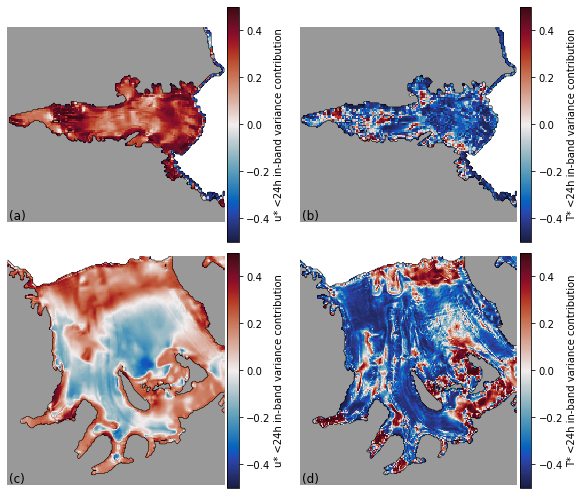

In [42]:
import string
fig,axes = plt.subplots(2,2,figsize=(8.27,7.0))

ax1,ax2,ax3,ax4 = axes.flatten()

ax1 = plot_map(ax1,var['tides']['ustar'].fast_contr.where(mask)-0.5,
               'ustar_var_contr','u* <24h in-band variance contribution',
               ocm.balance,'sat',cb_ext='neither',sel=sel_Amery)

ax2 = plot_map(ax2,var['tides']['Tstar'].fast_contr.where(mask)-0.5,
               'Tstar_var_contr','T* <24h in-band variance contribution',
               ocm.balance,'sat',cb_ext='neither',sel=sel_Amery)

ax3 = plot_map(ax3,var['tides']['ustar'].fast_contr.where(mask)-0.5,
               'ustar_var_contr','u* <24h in-band variance contribution',
               ocm.balance,'sat',cb_ext='neither',sel=sel_Ronne)

ax4 = plot_map(ax4,var['tides']['Tstar'].fast_contr.where(mask)-0.5,
               'Tstar_var_contr','T* <24h in-band variance contribution',
               ocm.balance,'sat',cb_ext='neither',sel=sel_Ronne)

for n,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.text(0.01, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, size=12)

plt.tight_layout()

out_path = os.path.join(fig_dir,'Tstarustar_varcon_details.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()